### ch06. 텍스트 분류를 위한 미세 튜닝

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow",
        "pandas"]

for p in pkgs:
    print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.7
numpy 버전: 1.26.4
tiktoken 버전: 0.11.0
torch 버전: 2.6.0
tensorflow 버전: 2.20.0
pandas 버전: 2.2.3


#### 6.2 데이터셋 준비
- 스팸 및 스팸아님 텍스트 메시지로 구성된 데이터셋을 분류하기 위해 LLM을 미세튜닝합니다.
- 먼저 데이터셋을 다운로드하고 압축을 풉니다.

In [2]:
# import urllib.request
# import zipfile
# import os
# from pathlib import Path

# url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# zip_path = "sms_spam_collection.zip"
# extracted_path = "sms_spam_collection"
# data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

# def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
#     if data_file_path.exists():
#         print(f"{data_file_path}가 이미 있어 다운로드 및 압축 해제를 건너 뜁니다.")
#         return
    
#     # 파일을 다운로드 합니다.
#     with urllib.request.urlopen(url) as response:
#         with open(zip_path, "wb") as out_file:
#             out_file.write(response.read())
    
#     # 파일 압축을 풉니다.
#     with zipfile.ZipFile(zip_path, "r") as zip_ref:
#         zip_ref.extractall(extracted_path)
    
#     # .tsv 파일 확장자를 추가합니다.
#     original_file_path = Path(extracted_path) / "SMSSpamCollection"
#     os.rename(original_file_path, data_file_path)
#     print(f"파일이 다운로드되어 {data_file_path}에 저장되었습니다.")
    
# try:
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
# except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
#     print(f"기본 URL 실패: {e}. 백업 URL을 시도합니다...")
#     url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
#     download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

- 데이터셋은 탭으로 구분된 텍스트 파일로 저장되며, 판다스 DataFrame으로 로드할 수 있습니다

In [3]:
import pandas as pd
from pathlib import Path

extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- 클래스 분포를 확인해 보면, 데이터에 "스팸"보다 "햄"이 훨신 많다는 것을 알 수 있습니다.

In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- 간단하게 하기 위해, 그리고 교육 목적으로 작은 데이터셋을 선호하기 때문에 (LLM을 더 빠르게 미세튜닝할 수 있음), 각 클래스마다
747개의 샘플이 포함되도록 데이터 세트를 서브샘플링(언더샘플링)합니다.

In [5]:
def create_balanced_dataset(df):
    # "스팸" 샘플 개수 세기
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # "스팸" 샘플 개수와 일치하도록 "햄"을 무작위로 샘플
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # "햄"과 "스팸"을 합침
    balanced_df = pd.concat([ham_subset, df[df["Label"]=="spam"]])
    
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


- 다음으로 문자열 클래스 레이블 "ham"과 "spam"을 정수 클래스 레이블 0과 1로 변경합니다.

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [7]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


- 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 무작위 분할하는 함수 정의

In [8]:
def random_split(df, train_frac, validation_frac):
    # 데이터프레임 전체 섞기
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    # 분할 인덱스 계산
    train_end = int(len(df) *train_frac)
    validation_end = train_end +  int(len(df) * validation_frac)
    
    # 데이터프레임 분할
    train_df = df[: train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)
    

### 6.3 데이터로더 만들기
- 텍스트 메시지의 길이가 다르다는 점에 유의. 배치에 여러 훈련 샘플을 결합하려면 다음 중 하나를 수행
    1. 데이터셋 또는 배치에서 가장 짧은 메시지 길이로 모든 메시지를 자르기
    2. 데이터셋 또는 배치에서 가장 긴 메시지 길이로 모든 메시지에 패딩을 추가
- 옵션 2를 선택하고 데이터셋에서 가장 긴 메시지에 맞춰 모든 메시지에 패딩을 추가
- 이를 위해 2장에서 설명한 대로 <|endoftext|>를 패딩 토큰으로 사용

In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- SpamDataset 클래스는 학습 데이터셋에서 가장 긴 시퀀스를 식별하고 다른 시퀀스에 패딩 토큰을 추가하여 해당 길이에 맟춥니다.

In [10]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        # 텍스트 토큰화
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # max_length보다 긴 시퀀스 자르기
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
            
        # 가장 긴 시퀀스에 맞춰 패딩하기
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) 
            for encoded_text in self.encoded_texts
        ]
        
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
        
    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        # max_length = 0
        # for encoded_text in self.encoded_texts:
        #     encoded_length = len(encoded_text)
        #     if encoded_length > max_length:
        #         max_length = encoded_length
        # return max_length
        return max(len(encoded_text) for encoded_text in self.encoded_texts)        

In [11]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- 또한 검증 세트와 테스트 세트를 가장 긴 훈련 시퀀스에 맞춰 패딩합니다.
- 검증 세트와 테스트 세트 샘플 중 가장 긴 훈련 세트 샘플보다 긴 샘플은 SpamDataset 코드에서
  encoded_text[:set.max_length]를 통해 잘림.
- 이 동작은 완전히 선택 사항이며, 검증 세트와 테스트 의 경우 모두 max_length=None으로 설정해도 잘 작동합니다.

In [12]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [13]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

- 검증 단계로서, 데이터 로더를 반복하고 각 배치에 120개의 토큰으로 구성된 8개의 훈련 샘플이 포함되어 있는지 확인

In [14]:
print("훈련 세트 로더: ")
for input_batch, target_batch in train_loader:
    pass

print("입력 배치 차원: ", input_batch.shape)
print("레이블 배치 차원: ", target_batch.shape)

훈련 세트 로더: 
입력 배치 차원:  torch.Size([8, 120])
레이블 배치 차원:  torch.Size([8])


- 마지막으로, 각 데이터셋의 총 배치 수를 출력해 보겠습니다.

In [15]:
print(f"{len(train_loader)}개 훈련 배치")
print(f"{len(val_loader)}개 검증 배치")
print(f"{len(test_loader)}개 테스트 배치")

130개 훈련 배치
19개 검증 배치
38개 테스트 배치


### 6.4 사전 훈련된 가중치로 모델 초기화하기

In [16]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘사전 크기
    "context_length": 1024,  # 문맥 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"데이터셋 길이 {train_dataset.max_length} 가 모델의 문맥"
    f"길이 {BASE_CONFIG['context_length']}를 초과합니다. `max_length={BASE_CONFIG['context_length']}`로" 
    f"데이터 셋을 다시 초기화하십시오."
)

In [17]:
!wget https://bit.ly/4jZL2Gr -O gpt_download.py
!wget https://bit.ly/4esl8dj -O previous_chapters.py

--2025-12-08 02:09:43--  https://bit.ly/4jZL2Gr
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch06/01_main-chapter-code/gpt_download.py [following]
--2025-12-08 02:09:43--  https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch06/01_main-chapter-code/gpt_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6333 (6.2K) [text/plain]
Saving to: ‘gpt_download.py’

gpt_download.py     100%[===================>]   6.18K  --.-KB/s    in 0s      

2025-12-08 02:09:43 (18.6 MB/s) - ‘gpt_download.py’ saved [6333/63

In [18]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

2025-12-08 02:09:44.857170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 02:09:44.889997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 02:09:45.786629: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 모델이 제대로 로드되었는지 확인하기 위해 일관된 텍스트를 생성하는 지 다시 확인

In [19]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- 모델을 분류기로 미세 튜닝하기 전에 프롬프트를 통해 스팸 메시지를 분류할 수 있는 지 확인

In [20]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


### 6.5 분류 헤드 추가하기

In [21]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 목표는 출력 층을 교체하고 미세 튜닝하는 것입니다.
- 이를 위해 먼저 모델을 동결

In [22]:
for param in model.parameters():
    param.requires_grad = False

In [23]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

- 기술적으로 출력 층만 훈련하는 것으로 충분
- 하지만, 대규모 언어 모델 미세 튜닝에서 확인했듯이, 실험 결과 추가 층을 미세 튜닝하면 성능이 눈에 띄게 향상.
- 따라서, 마지막 트랜스포머 블록과 마지막 트랜스포머 블록을 출력 층에 연결하는 최종 LayerNorm 모듈도 훈련 가능하도록 설정

In [24]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [25]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("입력:", inputs)
print("입력 차원:", inputs.shape)

입력: tensor([[5211,  345,  423,  640]])
입력 차원: torch.Size([1, 4])


In [26]:
with torch.no_grad():
    outputs = model(inputs)
    
print("출력:\n", outputs)
print("출력 차원:", outputs.shape)

출력:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
출력 차원: torch.Size([1, 4, 2])


In [27]:
print("마지막 출력 토큰:", outputs[:, -1, :])

마지막 출력 토큰: tensor([[-3.5983,  3.9902]])


### 6.6 분류 손실과 정확도 계산하기

In [28]:
print("마지막 출력 토큰: ", outputs[:,-1,:])

마지막 출력 토큰:  tensor([[-3.5983,  3.9902]])


In [29]:
probas = torch.softmax(outputs[:,-1,:], dim=-1)
label = torch.argmax(probas)
print("클래스 레이블:", label.item())

클래스 레이블: 1


- 5 장에서 설명했듯이 소프트맥스 함수는 여기서는 선택사항. 가장 큰 출력이이 가장 큰 확률 점수에 해당

In [30]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("클래스 레이블:", label.item())

클래스 레이블: 1


In [31]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]   # 마지막 출력 토큰의 로짓
            predicted_labels = torch.argmax(logits, dim=-1)
            
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
        
    return correct_predictions / num_examples
            

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
) 
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")


훈련 정확도: 46.25%
검증 정확도: 45.00%
테스트 정확도: 48.75%


In [33]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [34]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- calc_loss_loader를 사용하여 훈련을 시작하기 전 초기 훈련, 검증 및 테스트 세트 손실을 계산합니다.

In [35]:
with torch.no_grad():    # 효율성을 위해 그레디언트 추적을 비활성화.  아직 훈련하지 않기 때문.
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"훈련 손실: {train_loss:.3f}")
print(f"검증 손실: {val_loss:.3f}")
print(f"테스트 손실: {test_loss:.3f}") 

훈련 손실: 2.453
검증 손실: 2.583
테스트 손실: 2.322


### 6.7 지도학습 데이터로 모델 미세 튜닝하기
- 모델의 분류 정확도를 향상시키기 위한 훈련 함수를 정의하고 사용
- train_classifier_simple 함수는 5장에서 모델 사전 훈련에 사용했던 train_model_simple함수와 거의 동일합니다.
- 두 가지 차이점
  1. 토큰 수 대신 학습된 샘플 수(examples_seen)을 추적합니다.
  2. 각 에포크 다음에 샘플 텍스트를 출력하는 대신 정확도를 계산합니다.

In [36]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # 손실 및 처리한 샘플 수를 위한 리스크 초기화
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    # 메인 학습 루프
    for epoch in range(num_epochs):
        model.train()   # 모델을 훈련 모드로 설정
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()   # 이전 배치 반복에서 얻은 손실의 그레디어트 재설정
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # loss gradient 계산
            optimizer.step()    # loss gradient를 모델 가중치 업데이트
            examples_seen += input_batch.shape[0] # 새로 추가: 토큰 대신 샘플 추적
            global_step += 1
            
            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")
                
        # 각 에포크 후 정확도 계산
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"훈련 정확도: {train_accuracy*100:.2f}% | ", end="")
        print(f"검증 정확도: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [37]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [38]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"훈련 소요 시간: {execution_time_minutes:.2f}분")

에포크 1 (Step 000000): 훈련 손실 2.153, 검증 손실 2.392
에포크 1 (Step 000050): 훈련 손실 0.617, 검증 손실 0.637
에포크 1 (Step 000100): 훈련 손실 0.523, 검증 손실 0.557
훈련 정확도: 70.00% | 검증 정확도: 72.50%
에포크 2 (Step 000150): 훈련 손실 0.561, 검증 손실 0.489
에포크 2 (Step 000200): 훈련 손실 0.419, 검증 손실 0.397
에포크 2 (Step 000250): 훈련 손실 0.409, 검증 손실 0.353
훈련 정확도: 82.50% | 검증 정확도: 85.00%
에포크 3 (Step 000300): 훈련 손실 0.333, 검증 손실 0.320
에포크 3 (Step 000350): 훈련 손실 0.340, 검증 손실 0.306
훈련 정확도: 90.00% | 검증 정확도: 90.00%
에포크 4 (Step 000400): 훈련 손실 0.136, 검증 손실 0.200
에포크 4 (Step 000450): 훈련 손실 0.153, 검증 손실 0.132
에포크 4 (Step 000500): 훈련 손실 0.222, 검증 손실 0.137
훈련 정확도: 100.00% | 검증 정확도: 97.50%
에포크 5 (Step 000550): 훈련 손실 0.207, 검증 손실 0.143
에포크 5 (Step 000600): 훈련 손실 0.083, 검증 손실 0.074
훈련 정확도: 100.00% | 검증 정확도: 97.50%
훈련 소요 시간: 0.13분


In [39]:
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))
    
    # 훈련 및 검증 손실을 에포크에 따라 그립니다.
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    
    # 처리한 샘플 수를 위해 두 번째 x축을 만듭니다.
    ax2 = ax1.twiny()   # 동일한 y축을 공유하는 두 번째 x축을 만듭니다.
    ax2.plot(examples_seen, train_values, alpha=0)      # 눈금 정렬을 위한 보이지 않는 그래프
    ax2.set_xlabel("Examples seen")
    
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

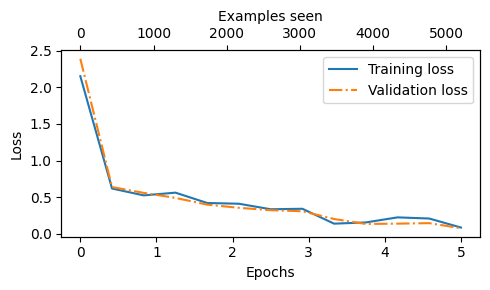

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

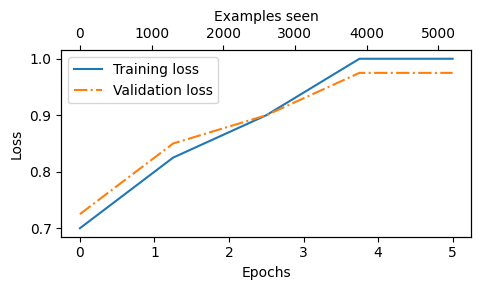

In [41]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs)

In [42]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 97.21%
검증 정확도: 97.32%
테스트 정확도: 95.67%


### 6.8 LLM을 스팸 분류기로 사용하기

In [44]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    
    # 모델에 대한 입력 준비
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    
    # 너무 긴 시퀀스 자르기
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length가 지정되지 않았습니다. 모델의 최대 문맥 길이를 사용하려면"
        "max_length=model.pos_emb.weight.shape[0]로 지정하세요."
    )
    assert max_length <= supported_context_length, (
        f"max_length({max_length})가 모델이 지원하는 문맥 길이({supported_context_length})를 초과했습니다."
    )
    
    # 가장 긴 시퀀스 패딩하기
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)  # 배치 차원 추가
    
    # 모델 추론
    with torch.no_grad():
        logits = model(input_tensor)[:,-1,:]    # 마지막 출력 토큰의 로짓
    predicted_label = torch.argmax(logits,dim=-1).item()
    
    # 분류 결과 반환
    return "스팸" if predicted_label == 1 else "스팸아님"

In [45]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

스팸


In [46]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

스팸아님


- 마지막으로, 나중에 다시 훈련하지 않고 모델을 재사용할 수 있도록 모델을 저장합니다.

In [47]:
torch.save(model.state_dict(), "review_classifier.pth")

In [48]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>